# Pneumonia Prediction From DICOM Files

This notebook explores and creates functions for loading and screening DICOM files and finally running the deep learning CNN model on the X-Ray image to return a prediction of Pneumonia or No Pneumonia.

The DICOM function checks that the DICOM file has characteristics that fall into the scope of the model. The function checks that the age range is between 1 and 95, the body part is the chest, the position is AP or PA, and that the modality is DX. These are the characteristics of the images that were to develop the model and must be used for the model to perform properly.

In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

In [3]:
ds = pydicom.dcmread('test1.dcm')
ds.dir()

['BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'HighBit',
 'Modality',
 'PatientAge',
 'PatientID',
 'PatientPosition',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'StudyDescription',
 'StudyInstanceUID']

## Create functions for working with DICOM files

The required functions for working with a DICOM file are:

**check_dicom** - load the dicom file and check that the age range, body part, patient position, and modality are appropriate.

**preprocess_image** - reshapes the pixel array into an appropriate shape for the model

**load_model** - gets the CNN model file and the weights and properly loads them

**predict_image** - inputs the preprocessed image into the loaded model to return a prediction

In [4]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename, verbose=False): 
    
        
    # create an empty line for space in the printout
    print('\n')
    # show the file being processed
    print('Load file {} ...'.format(filename))
    
    # read the dicom file
    ds = pydicom.dcmread(filename)       
    
    if verbose == True:
        # print out the relevant metadata
        print(f'Patient ID: {ds.PatientID}')
        print(f'Patient Age: {ds.PatientAge}')
        print(f'Patient Sex: {ds.PatientSex}')
        print(f'Body Part: {ds.BodyPartExamined}')
        print(f'Patient Position: {ds.PatientPosition}')
        print(f'Modality: {ds.Modality}')
        print(f'Study Description: {ds.StudyDescription}')
        print(f'Columns: {ds.Columns}')
        print(f'Rows: {ds.Rows}')
    
    # check age range of the patient to the model's limitations
    if int(ds.PatientAge) < 1 or int(ds.PatientAge) > 95:
        print(f'The file {filename} has been rejected because the patient age, {ds.PatientAge}, is outside the range 1-95.')
        return None
    
    # check the body part is chest
    if ds.BodyPartExamined != 'CHEST':
        print(f'The file {filename} has been rejected because the body part examined, {ds.BodyPartExamined}, is not CHEST.')
        return None
    
    # check that the patient position is AP or PA
    if ds.PatientPosition not in ['PA', 'AP']:
        print(f'The file {filename} has been rejected because the patient position, {ds.PatientPosition}, is not AP or PA.')
        return None
        
    # check that the modality is DX (Digital Radiography)
    if ds.Modality != 'DX':
        print(f'The file {filename} has been rejected because the patient position, {ds.Modality}, is not DX (Digital Radiography).')
        return None
    
    # if the image passes all the limitations for the model
    # create the image variable
    img = ds.pixel_array
    
    return img
    
    

    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_mean, img_std, img_size, verbose=False): 
    
    if verbose == True:
        print(f'Original Image Shape: {img.shape}')
    
    # cresize the image to (224, 224) for the proper size for the model
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)
    
    if verbose == True:
        print(f'Data resized to {resized_img.shape}')
    
    # reshape the image to (1, 224, 224, 3) for the model
    reshaped_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    reshaped_img = np.repeat(reshaped_img, img_size[3], axis=3)
    
    if verbose == True:
        print(f'Final data shape is {reshaped_img.shape}')
    
    return reshaped_img




# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    
    # open the json file
    file = open(model_path, 'r')
    # read the file
    model_json = file.read()
    # create final model from json model
    model = model_from_json(model_json)
    
    # load the weigths for the neural network
    model.load_weights(weight_path)
    print(f'The loaded model is: {model}')
    
    return model



# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, threshold): 
    
    # use model to return probability prediction 
    preds = model.predict(img)
    
    # use the threshold to convert to a classification
    if preds > threshold:
        prediction = 'Pneumonia'
    else: 
        prediction = 'No Pneumonia'
        

    return prediction

## Test the new functions

In [5]:
# retrieve the first test image
first_img = check_dicom('test1.dcm')



Load file test1.dcm ...


In [6]:
# preprocess the image to make applicable to the model
processed_img = preprocess_image(first_img, 1, 1, (1,224, 224,3))

## Perform the predictions from the DICOM files

In [7]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model_1.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = 1 # place holder that will not be used in this model
img_std = 1 # place holder that will not be used in this model

my_model = load_model(model_path, weight_path)
thresh = 0.47 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

The loaded model is: <keras.engine.sequential.Sequential object at 0x7f5ca9aaebd0>


Load file test1.dcm ...
No Pneumonia


Load file test2.dcm ...
No Pneumonia


Load file test3.dcm ...
Pneumonia


Load file test4.dcm ...
The file test4.dcm has been rejected because the body part examined, RIBCAGE, is not CHEST.


Load file test5.dcm ...
The file test5.dcm has been rejected because the patient position, CT, is not DX (Digital Radiography).


Load file test6.dcm ...
The file test6.dcm has been rejected because the patient position, XX, is not AP or PA.


## Analysis of the Test DICOM files

The first two DICOM files were predicted to have No Pneumonia, while the third file was predicted to have Pneumonia.

Test files 4, 5, and 6 were rejected because of they did not fit into the guidelines for the intended use for this model.

# Use the Model for Further Analysis of Larger Data

In [8]:
import os
from glob import glob

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Image_Path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image_Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [9]:
# split the finding labels
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].str.split('|')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image_Path
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [10]:
# create unique set of finding labels
unique_labels = []
for idx, row in all_xray_df.iterrows():
    for label in row['Finding Labels']:
        if label not in unique_labels:
            unique_labels.append(label)
            
unique_labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No Finding',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

In [11]:
# set a column to Pneumonia
for idx, row in all_xray_df.iterrows():
    if 'Pneumonia' in row['Finding Labels']:
        all_xray_df.loc[idx, 'Pneumonia'] = 'Pneumonia'
    else:
        all_xray_df.loc[idx, 'Pneumonia'] = 'No Pneumonia'
        
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image_Path,Pneumonia
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,No Pneumonia
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,No Pneumonia
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,No Pneumonia
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,No Pneumonia
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,No Pneumonia


In [12]:
# drop the Unnamed: 11 column
all_xray_df = all_xray_df.drop(columns=['Unnamed: 11'])

## Make Predictions on the All X-Ray Dataframe

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as image

In [14]:
# create a function to get predictions
def pneumonia_pred(img_path, thresh=0.47):
    # read in the image
    img_data = image.imread(img_path)
    # preprocess the image
    preprocess_img = preprocess_image(img_data, 1, 1, (1, 224, 224, 3))
    # make the prediction
    pred = predict_image(my_model,preprocess_img,thresh)
    
    return pred

In [15]:
# split the dataframe into pneumonia and non-pneumonia
pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 'Pneumonia']
no_pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 'No Pneumonia']

# create a sample of no_pneumonia_df 3 times the size of pneumonia, more similar to real-world distribution
sample_no_pneum = no_pneumonia_df.sample(len(pneumonia_df)*3).copy()

In [16]:
# concatenate the two dataframes
test_df = pd.concat([pneumonia_df, sample_no_pneum])

In [17]:
test_df.Pneumonia.value_counts()

No Pneumonia    4293
Pneumonia       1431
Name: Pneumonia, dtype: int64

In [18]:
#get predictions for the test_df
for idx, row in test_df.iterrows():
    try:
        test_df.loc[idx, 'Prediction_47'] = pneumonia_pred(test_df.loc[idx, 'Image_Path'])
    except:
        test_df.loc[idx, 'Prediction_47'] = None
        print('Not proper image dimensions for index', idx)


Not proper image dimensions for index 2921
Not proper image dimensions for index 3848
Not proper image dimensions for index 17764
Not proper image dimensions for index 20331
Not proper image dimensions for index 26051
Not proper image dimensions for index 57302
Not proper image dimensions for index 57328
Not proper image dimensions for index 57329
Not proper image dimensions for index 104088
Not proper image dimensions for index 110474
Not proper image dimensions for index 8404
Not proper image dimensions for index 13162
Not proper image dimensions for index 21455
Not proper image dimensions for index 23579
Not proper image dimensions for index 10166
Not proper image dimensions for index 18570
Not proper image dimensions for index 57051
Not proper image dimensions for index 12068
Not proper image dimensions for index 22057
Not proper image dimensions for index 16630
Not proper image dimensions for index 26586
Not proper image dimensions for index 405
Not proper image dimensions for ind

In [19]:
# check for the percentage of None values in predictions
test_df['Prediction_47'].isna().sum() / len(test_df)

0.005241090146750524

In [20]:
# drop the None rows from Prediction_47
test_df = test_df.dropna()
len(test_df)

5694

In [21]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image_Path,Pneumonia,Prediction_47
48,00000013_010.png,"[Effusion, Pneumonia, Pneumothorax]",10,13,60,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_010.png,Pneumonia,Pneumonia
126,00000032_012.png,"[Atelectasis, Consolidation, Edema, Pneumonia]",12,32,55,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_012.png,Pneumonia,Pneumonia
253,00000056_000.png,"[Nodule, Pneumonia]",0,56,76,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000056_000.png,Pneumonia,No Pneumonia
276,00000061_012.png,"[Edema, Effusion, Infiltration, Pleural_Thicke...",12,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_012.png,Pneumonia,Pneumonia
279,00000061_015.png,[Pneumonia],15,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_015.png,Pneumonia,Pneumonia


In [22]:
test_df['Pneumonia'].value_counts()

No Pneumonia    4273
Pneumonia       1421
Name: Pneumonia, dtype: int64

## Statistics on the Predictions

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
tn, fp, fn, tp = confusion_matrix(test_df['Pneumonia'], test_df['Prediction_47']).ravel()
print(tn, fp, fn, tp)

3205 1068 686 735


In [31]:
# sanity check that the true positives and true negatives are correct

# get the tn
tn = 0
# get the tp
tp = 0

# iterate through the pneumonia and prediction columns to assign tn and tp
for i in test_df.index:
    if test_df.loc[i,'Pneumonia'] == 'No Pneumonia':
        if test_df.loc[i, 'Prediction_47'] == 'No Pneumonia':
            tn += 1
    elif test_df.loc[i, 'Pneumonia'] == 'Pneumonia':
        if test_df.loc[i, 'Prediction_47'] == 'Pneumonia':
            tp += 1
print(tn, tp)

3205 735


The true negatives are 3205 in both versions and true positives are 735 in both. This confirms the confusion matrix is correct.

In [32]:
precision = tp / (tp + fp)

recall = tp / (tp + fn)

accuracy = (tp + tn) / (tp + fn + fp + tn)

f1 = 2 * (precision*recall) / (precision + recall)

In [33]:
# print the statistics for threshold .47
print('Statistics for Threshold 0.47')
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Statistics for Threshold 0.47
Precision: 0.40765391014975044
Recall: 0.5172413793103449
Accuracy: 0.6919564453811029
F1 Score: 0.4559553349875931


## Try different thresholds with the model

In [34]:
# create a function to split the dataframe more balanced for pneumonia
def df_split(df):
    
    # split the dataframe into pneumonia and non-pneumonia
    pneumonia_df = df[df['Pneumonia'] == 'Pneumonia']
    no_pneumonia_df = df[df['Pneumonia'] == 'No Pneumonia']

    # create a sample of no_pneumonia_df two times the size of pneumonia
    sample_no_pneum = no_pneumonia_df.sample(len(pneumonia_df)*2).copy()
    
    # concatenate the two dataframes
    test_df = pd.concat([pneumonia_df, sample_no_pneum])
    print('df sampling complete')
    
    return test_df

In [35]:
# Create predictions
def run_model(model, df):
        
    pred_df = df.copy()
    
    #get predictions for the pred_df
    for idx, row in pred_df.iterrows():
        try:
            # read in the image
            img_data = image.imread(pred_df.loc[idx, 'Image_Path'])
            #preprocess the image
            preprocess_img = preprocess_image(img_data, 1, 1, (1, 224, 224, 3))
            # make the prediction
            pred = model.predict(preprocess_img)
            # assign the prediction to the prediction column
            pred_df.loc[idx, 'Prediction'] = pred[0]
        except:
            pred_df.loc[idx, 'Prediction'] = None
        
    # drop the rows with None for Prediction    
    pred_df = pred_df.dropna()
    
    return pred_df

In [42]:
# create a function that returns different statistics based on the threshold
def model_stats(df, threshold=0.47):
    
    # create a new column for classification
    df['Prediction_Class'] = df['Prediction']

    # convert the probability into a classification
    df['Prediction_Class'] = df['Prediction_Class'].apply(lambda x: 'Pneumonia' if x > threshold else 'No Pneumonia')
    
    # get the statistics
    tn, fp, fn, tp = confusion_matrix(df['Pneumonia'], df['Prediction_Class']).ravel()

    # get the relevant statistics
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision*recall) / (precision + recall)
    
    print('Model predictions complete')
    
    return precision, recall, accuracy, specificity, f1, threshold

In [43]:
# create a dataframe of prediction probabilities
predictions_df = run_model(my_model, test_df)

In [44]:
predictions_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image_Path,Pneumonia,Prediction_47,Prediction
48,00000013_010.png,"[Effusion, Pneumonia, Pneumothorax]",10,13,60,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_010.png,Pneumonia,Pneumonia,0.486139
126,00000032_012.png,"[Atelectasis, Consolidation, Edema, Pneumonia]",12,32,55,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_012.png,Pneumonia,Pneumonia,0.527009
253,00000056_000.png,"[Nodule, Pneumonia]",0,56,76,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000056_000.png,Pneumonia,No Pneumonia,0.393422
276,00000061_012.png,"[Edema, Effusion, Infiltration, Pleural_Thicke...",12,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_012.png,Pneumonia,Pneumonia,0.704641
279,00000061_015.png,[Pneumonia],15,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_015.png,Pneumonia,Pneumonia,0.717620


In [45]:
# iterate through various thresholds and return statistics
thresholds = [x / 100 for x in list(range(20, 85, 5))]

# create dictionary for storing results
model_results = {}

for threshold in thresholds:
    prec, rec, acc, spec, f1, thresh = model_stats(predictions_df, threshold=threshold)
    model_results[threshold] = {'precision':prec, 'recall':rec, 'accuracy':acc, 'specificity':spec, 'F1':f1}
    print('Threshold Testing:', threshold)

Model predictions complete
Threshold Testing: 0.2
Model predictions complete
Threshold Testing: 0.25
Model predictions complete
Threshold Testing: 0.3
Model predictions complete
Threshold Testing: 0.35
Model predictions complete
Threshold Testing: 0.4
Model predictions complete
Threshold Testing: 0.45
Model predictions complete
Threshold Testing: 0.5
Model predictions complete
Threshold Testing: 0.55
Model predictions complete
Threshold Testing: 0.6
Model predictions complete
Threshold Testing: 0.65
Model predictions complete
Threshold Testing: 0.7
Model predictions complete
Threshold Testing: 0.75
Model predictions complete
Threshold Testing: 0.8


In [46]:
for thresh in thresholds:
    print('Threshold', thresh)
    print(model_results[thresh])
    print('--------------------------------------')
    print('\n')

Threshold 0.2
{'precision': 0.2774674115456238, 'recall': 0.9437016185784659, 'accuracy': 0.3726729891113453, 'specificity': 0.182775567516967, 'F1': 0.42884553885513277}
--------------------------------------


Threshold 0.25
{'precision': 0.29346804511278196, 'recall': 0.8789584799437016, 'accuracy': 0.44169301018616086, 'specificity': 0.29627896091738826, 'F1': 0.44002113792496034}
--------------------------------------


Threshold 0.3
{'precision': 0.31645223104297837, 'recall': 0.8135116115411682, 'accuracy': 0.5149279943800492, 'specificity': 0.41563304469927453, 'F1': 0.4556562869530943}
--------------------------------------


Threshold 0.35
{'precision': 0.3460391117003646, 'recall': 0.7346938775510204, 'accuracy': 0.587284861257464, 'specificity': 0.5382635150947812, 'F1': 0.47048219918882384}
--------------------------------------


Threshold 0.4
{'precision': 0.3678714859437751, 'recall': 0.6446164672765659, 'accuracy': 0.6348788198103267, 'specificity': 0.6316405335829628,

## Analysis of Thresholds on the Model:

Since this model will be used for assisting a radiologist, the most import impact will be if the model can alert the doctor to potential pneumonia cases and then have the doctor confirm whether those cases are truly pneumonia. False positives are not as worrisome, since the patient is not at a health risk and the doctor can rule those out. What is more important to minimize the number of false negatives, which are missed pneumonia labeling.

In that case, determining the threshold should be more weighted towards **Recall** since that will **minimize the number of False Negatives**.

Some **Precision** can be sacrificed to improve the **Recall**.

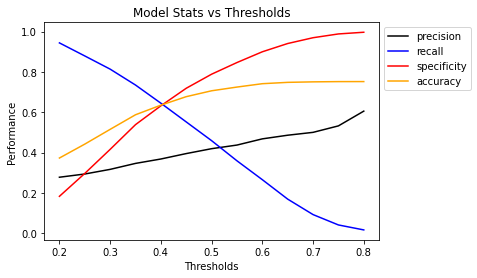

In [47]:
# plot the recall vs precision for the thresholds
precisions = []
recalls = []
accuracies = []
specificities = []

for val in thresholds:
    precisions.append(model_results[val]['precision'])
    recalls.append(model_results[val]['recall'])
    specificities.append(model_results[val]['specificity'])
    accuracies.append(model_results[val]['accuracy'])
    
plt.plot(thresholds, precisions, color='black', label='precision')
plt.plot(thresholds, recalls, color='blue', label='recall')
plt.plot(thresholds, specificities, color='red', label='specificity')
plt.plot(thresholds, accuracies, color='orange', label='accuracy')
plt.title('Model Stats vs Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Performance')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

plt.show()

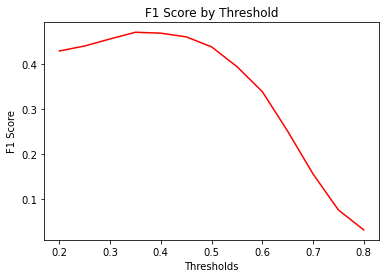

In [48]:
# create an array of F1 scores
f1_list = []

for thresh in thresholds:
    f1_list.append(model_results[thresh]['F1'])
    
plt.plot(thresholds, f1_list, color='red')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold')
plt.show()

## Analysis of Model Stats Plot

The **Recall** steadily declines throughout the range from 0.2 to 0.8 threholds.

The **Specificity** increases rapidly from 0.2 to 0.45 threshold.

The **Precision** steadily increases at a low rate til 0.7 threshold.

The **Accuracy** improves most rapidly from 0.2 to 0.35 and then starts leveling off for the rest.

The **F1 Score** slowly improves from 0.2 to 0.4 then declines from 0.45 to 0.8 threshold.

This leads me to believe that the **best threshold** would be around **0.30** to get a **strong amount of Recall** while also getting **near the max of the Accuracy**. As well, the amount of Precision is not as important for this use case as Recall, so erring on the lower side of Precision is not a major factor. 


In [49]:
# print out the stats for threshold 0.30
best_thresh = model_results[0.30]
print("Threshold 0.30 Results")
print("----------------------------")
print("Recall:", best_thresh['recall'])
print("Accuracy:", best_thresh['accuracy'])
print("F1:", best_thresh['F1'])
print("Precision:", best_thresh['precision'])
print("Specificity:", best_thresh['specificity'])

Threshold 0.30 Results
----------------------------
Recall: 0.8135116115411682
Accuracy: 0.5149279943800492
F1: 0.4556562869530943
Precision: 0.31645223104297837
Specificity: 0.41563304469927453


## Final Model Statistical Analysis

For this model, on the fairly evenly distributed using threshold 0.30, the model is correctly predicting 81% of the pneumonia cases.

The rate of False Positives is quite high since of all the pneumonia predictions 41% will be false positives which can be deduced from the 1 - Precision.

A stated earlier, a radiologist will still be observing the images, but the pneumonia prediction could prioritize which images the doctor sees first and then a final decision is made by the doctor.

## Look for Co-morbidities With High False Negatives

These are co-morbities with a low Recall value

In [50]:
# remove prediction_47 and prediction_class columns
predictions_df = predictions_df.drop(columns=['Prediction_47', 'Prediction_Class'])
predictions_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image_Path,Pneumonia,Prediction
48,00000013_010.png,"[Effusion, Pneumonia, Pneumothorax]",10,13,60,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_010.png,Pneumonia,0.486139
126,00000032_012.png,"[Atelectasis, Consolidation, Edema, Pneumonia]",12,32,55,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_012.png,Pneumonia,0.527009
253,00000056_000.png,"[Nodule, Pneumonia]",0,56,76,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000056_000.png,Pneumonia,0.393422
276,00000061_012.png,"[Edema, Effusion, Infiltration, Pleural_Thicke...",12,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_012.png,Pneumonia,0.704641
279,00000061_015.png,[Pneumonia],15,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_015.png,Pneumonia,0.717620


In [51]:
# save the predictions dataframe for use later
predictions_df.to_csv('pneumonia_predictions_df.csv', index=False)

In [52]:
preds_df = pd.read_csv('pneumonia_predictions_df.csv')
preds_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image_Path,Pneumonia,Prediction
0,00000013_010.png,"['Effusion', 'Pneumonia', 'Pneumothorax']",10,13,60,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_010.png,Pneumonia,0.486139
1,00000032_012.png,"['Atelectasis', 'Consolidation', 'Edema', 'Pne...",12,32,55,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_012.png,Pneumonia,0.527009
2,00000056_000.png,"['Nodule', 'Pneumonia']",0,56,76,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000056_000.png,Pneumonia,0.393422
3,00000061_012.png,"['Edema', 'Effusion', 'Infiltration', 'Pleural...",12,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_012.png,Pneumonia,0.704641
4,00000061_015.png,['Pneumonia'],15,61,77,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000061_015.png,Pneumonia,0.717620


In [53]:
# make predictions based on the 0.30 threshold
preds_df['Prediction_Class'] = preds_df['Prediction'].apply(lambda x: 'Pneumonia' if x > 0.30 else 'No Pneumonia')

In [54]:
comorbidities = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                 'Atelectasis','Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
    

In [55]:
# create a dictionary for the diseases and recall
dis_recall = {}
# create a dictionary for the diseases and f1 score
dis_f1 = {}

for disease in comorbidities:
    tp, tn, fp, fn = 0, 0, 0, 0
    
    for i in range(len(preds_df)):
        if disease in preds_df.loc[i, 'Finding Labels']:
            if preds_df.loc[i, 'Prediction_Class'] == 'Pneumonia':
                if preds_df.loc[i, 'Pneumonia'] == 'Pneumonia':
                    tp += 1
                else:
                    fn += 1
            elif preds_df.loc[i, 'Prediction_Class'] == 'No Pneumonia':
                if preds_df.loc[i, 'Pneumonia'] == 'No Pneumonia':
                    tn += 1
                else:
                    fp += 1
                
    # calculate the recall
    recall = tp / (tp + fn)
    # calculate the precision
    precision = tp / (tp+fp)
    
    # assign the recall value to the disease
    dis_recall[disease] = recall
    # assign the f1 score to the disease
    dis_f1[disease] = 2*(precision * recall) / (precision + recall)


True Positives: 110
False Positives: 13
True Negatives: 19
False Negatives: 157


<function matplotlib.pyplot.show(*args, **kw)>

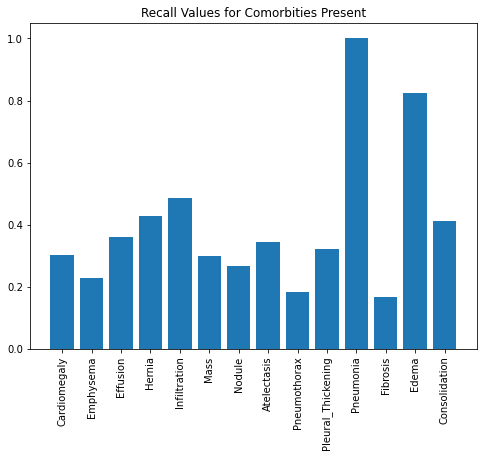

In [56]:
plt.figure(figsize=(8,6))
plt.bar(dis_recall.keys(), dis_recall.values())
ax = plt.gca()
ax.set_xticklabels(labels=dis_recall.keys(),rotation=90)
plt.title('Recall Values for Comorbities Present')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

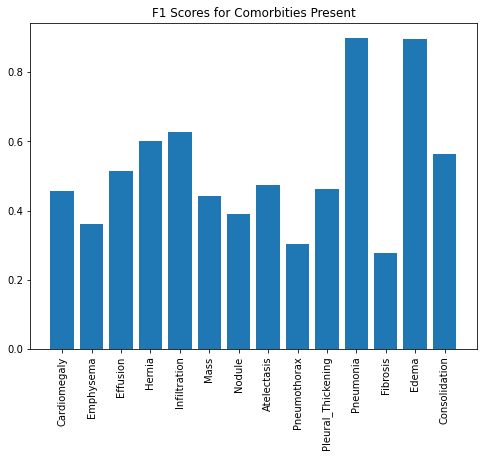

In [57]:
plt.figure(figsize=(8,6))
plt.bar(dis_f1.keys(), dis_f1.values())
ax = plt.gca()
ax.set_xticklabels(labels=dis_f1.keys(),rotation=90)
plt.title('F1 Scores for Comorbities Present')
plt.show

In [58]:
print('Fibrosis Stats:')
print('Recall:', dis_recall['Fibrosis'])
print('F1 Score:', dis_f1['Fibrosis'])
print('\nPneumothorax Stats:')
print('Recall:', dis_recall['Pneumothorax'])
print('F1 Score:', dis_f1['Pneumothorax'])

Fibrosis Stats:
Recall: 0.16666666666666666
F1 Score: 0.2769230769230769

Pneumothorax Stats:
Recall: 0.18274111675126903
F1 Score: 0.3025210084033613


### Fibrosis and Pneumothorax have a significant impact on the performance of the model to detect Pneumonia

Both comorbities of Fibrosis and Pneumothorax are a limitations of this model. This means the model should likely not be used if either of these diseases are known to be present in the patient.